In [1]:
import matplotlib.pyplot as plt
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.proposals import recom
from functools import partial
import pandas
from gerrychain.tree import recursive_tree_part

from gerrychain.metrics import efficiency_gap, mean_median

import geopandas as gpd

import os

from gerrychain.constraints.contiguity import contiguous_components, contiguous

import numpy as np

In [6]:
g = Graph.from_json("./Downloads/MAUP Code/Precinct_Graph_connected_CON.json")

In [7]:
df = gpd.read_file("./Downloads/MAUP Code/Processed_Precincts.shp")

In [8]:
df = df.drop(407)

<Axes: >

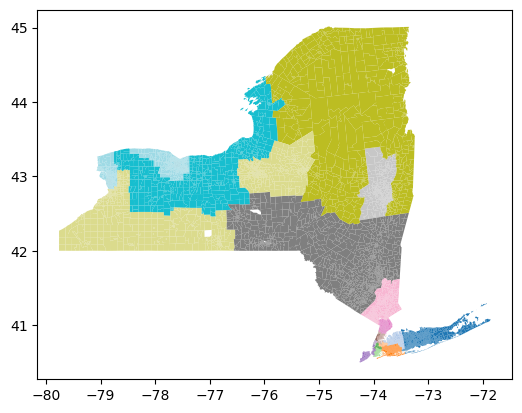

In [9]:
df.plot(column='CON',cmap='tab20')

In [10]:
len(df['CON'].unique())

26

In [11]:
sorted(df['CON'].unique())

[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0]

In [12]:
df.groupby('CON')["Population"].sum()

CON
0.0     776816.0
1.0     777013.0
2.0     776431.0
3.0     777175.0
4.0     776612.0
5.0     777817.0
6.0     777877.0
7.0     778000.0
8.0     773185.0
11.0    777036.0
12.0    779434.0
13.0    778278.0
14.0    776484.0
15.0    774786.0
16.0    779412.0
17.0    775288.0
18.0    775549.0
19.0    777716.0
20.0    774573.0
21.0    776356.0
22.0    779292.0
23.0    777919.0
24.0    775138.0
25.0    773907.0
26.0    776983.0
27.0    777359.0
Name: Population, dtype: float64

In [13]:
df.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTY', 'PRECINCT', 'G20PREDBID', 'G20PRERTRU',
       'G20PRELJOR', 'G20PREGHAW', 'G20PREIPIE', 'G20PREOWRI', 'CON', 'SLDL',
       'SLDU', 'Population', 'geometry'],
      dtype='object')

In [14]:
elections = [
    Election("G20PRE", {"Democratic": "G20PREDBID", "Republican": "G20PRERTRU"}),

]

for node in g.nodes():
    if g.nodes[node]['Population'] ==g.nodes[node]['Population']:
        g.nodes[node]['population'] = g.nodes[node]['Population']
    else:
        g.nodes[node]['population'] = 0
        
        

my_updaters = {"population": updaters.Tally("population", alias="population")}
election_updaters = {election.name: election for election in elections}
my_updaters.update(election_updaters)

initial_partition = GeographicPartition(g, assignment="CON", updaters=my_updaters)

In [15]:
contiguous(initial_partition)

True

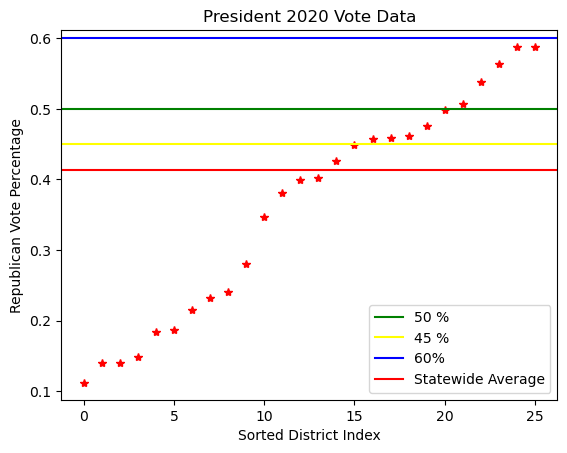

In [16]:

plt.plot(sorted(initial_partition['G20PRE'].percents('Republican')),'r*')
plt.axhline(.5,color='green',label= '50 %')
plt.axhline(.45,color='yellow', label='45 %')
plt.axhline(.6,color='blue',label='60%')

plt.axhline(.4134,color='red',label='Statewide Average')
plt.xlabel('Sorted District Index')
plt.ylabel('Republican Vote Percentage')
plt.title('President 2020 Vote Data')

plt.legend()


In [17]:
initial_partition['population']

{21.0: 776356.0,
 24.0: 775138.0,
 20.0: 774573.0,
 25.0: 773907.0,
 22.0: 779292.0,
 19.0: 777716.0,
 18.0: 775549.0,
 27.0: 777359.0,
 23.0: 777919.0,
 26.0: 776983.0,
 3.0: 777175.0,
 2.0: 776431.0,
 1.0: 777013.0,
 4.0: 776612.0,
 6.0: 777877.0,
 5.0: 777817.0,
 15.0: 774786.0,
 8.0: 773185.0,
 7.0: 778000.0,
 11.0: 777036.0,
 12.0: 779434.0,
 13.0: 778278.0,
 14.0: 775124.0,
 16.0: 780772.0,
 17.0: 775288.0,
 0.0: 776816.0}

In [18]:
df.groupby("CON")["Population"].sum()

CON
0.0     776816.0
1.0     777013.0
2.0     776431.0
3.0     777175.0
4.0     776612.0
5.0     777817.0
6.0     777877.0
7.0     778000.0
8.0     773185.0
11.0    777036.0
12.0    779434.0
13.0    778278.0
14.0    776484.0
15.0    774786.0
16.0    779412.0
17.0    775288.0
18.0    775549.0
19.0    777716.0
20.0    774573.0
21.0    776356.0
22.0    779292.0
23.0    777919.0
24.0    775138.0
25.0    773907.0
26.0    776983.0
27.0    777359.0
Name: Population, dtype: float64

In [19]:
ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)

# We use functools.partial to bind the extra parameters (pop_col, pop_target, epsilon, node_repeats)
# of the recom proposal.
proposal = partial(recom,
                   pop_col="population",
                   pop_target=ideal_population,
                   epsilon=0.02,
                   node_repeats=2
                  )



In [20]:
compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(initial_partition["cut_edges"])
)

pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, 0.05)

In [21]:
chain = MarkovChain(
    proposal=proposal,
    constraints=[
        pop_constraint,
        compactness_bound
    ],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=10
)

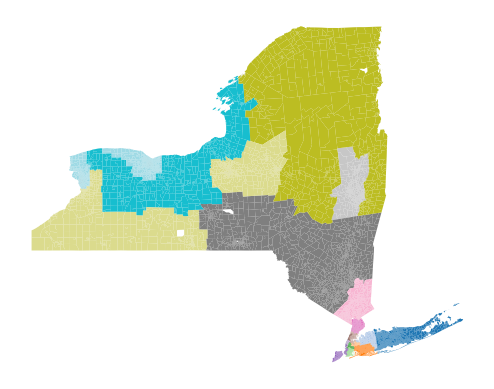

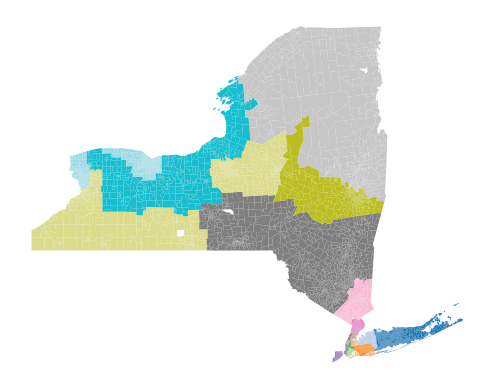

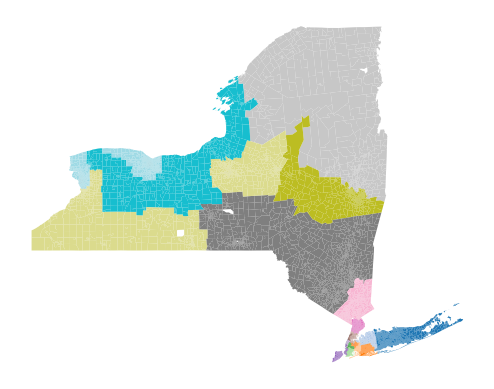

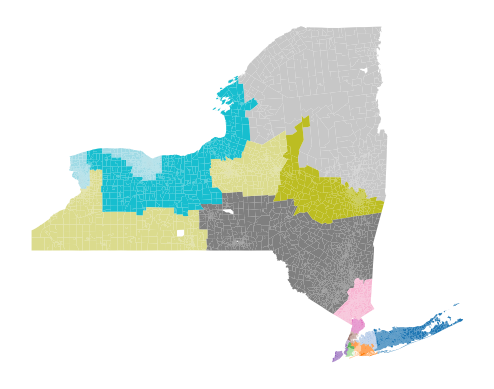

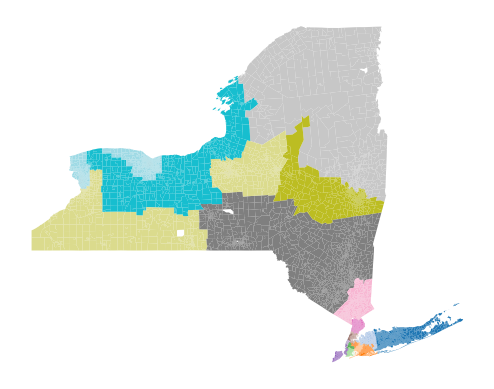

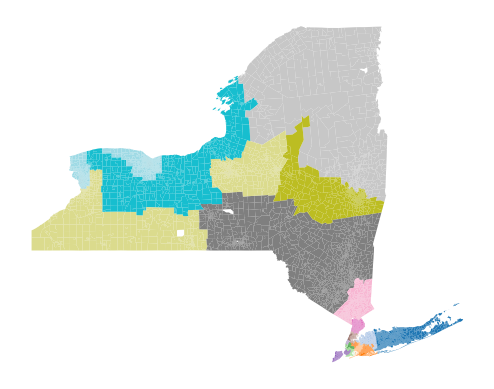

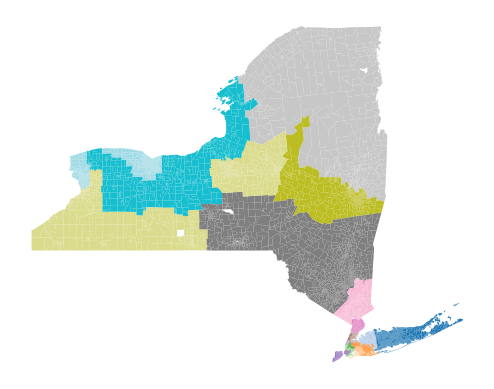

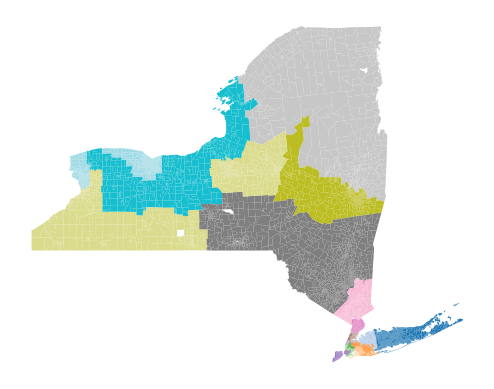

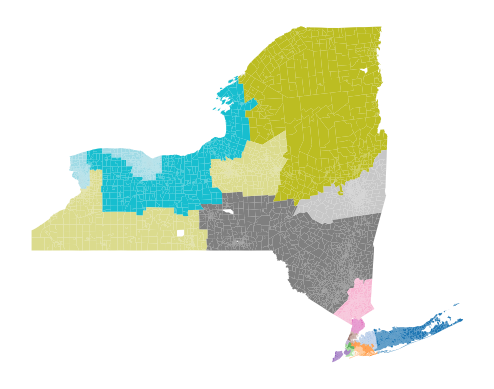

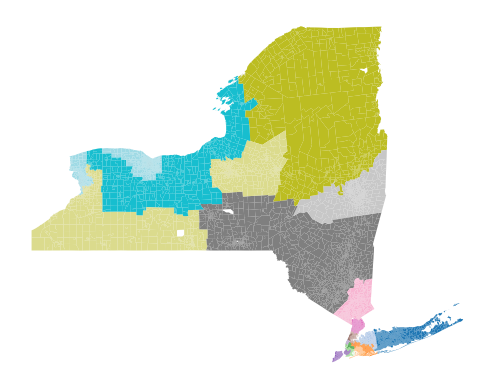

In [22]:
egs = []
mms = []
for partition in chain:
    egs.append(efficiency_gap(partition['G20PRE']))
    mms.append(mean_median(partition['G20PRE']))
    
    df['Current_assignment'] = df.index.map(dict(partition.assignment))
    df.plot(column='Current_assignment',cmap='tab20')
    plt.axis('off')
    plt.show()


(array([7., 0., 0., 0., 0., 0., 1., 0., 1., 1.]),
 array([0.0554183 , 0.05576692, 0.05611555, 0.05646418, 0.0568128 ,
        0.05716143, 0.05751005, 0.05785868, 0.05820731, 0.05855593,
        0.05890456]),
 <BarContainer object of 10 artists>)

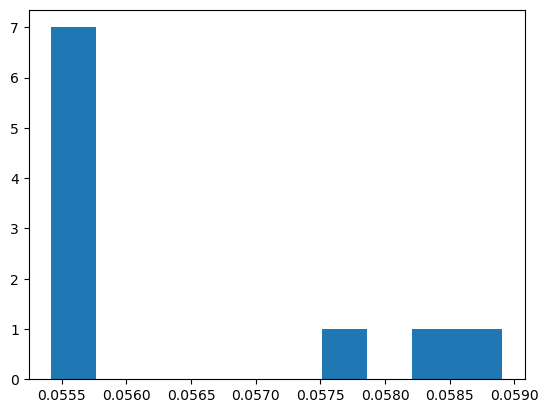

In [23]:
plt.hist(egs)

In [24]:
chain2 = MarkovChain(
    proposal=proposal,
    constraints=[
        pop_constraint,
        compactness_bound
    ],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=100
)

In [26]:
newpath = './NY_First_Plots'
if not os.path.exists(newpath):
    os.makedirs(newpath)

egs = []
mms = []
t=0
s=0
plt.close()
for partition in chain2:
    
    egs.append(efficiency_gap(partition['G20PRE']))
    mms.append(mean_median(partition['G20PRE']))
    
    
    if t % 1 ==0:
        print(t)
    
        df['Current_assignment'] = df.index.map(dict(partition.assignment))
        df.plot(column='Current_assignment',cmap='tab20')
        plt.axis('off')
        if egs[-1] <0:
            plt.title(f'Efficiency Gap: {egs[-1]:.4f}',color='red')
        else:
            plt.title(f'Efficiency Gap: {egs[-1]:.4f}',color='blue')
        #plt.show()
        plt.savefig(f'{newpath}/step_{s:03d}.png')
        s+=1


        plt.close()
    
    t+=1




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
